# Setup

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import emoji
from warnings import filterwarnings

import string
import nltk
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, RegexpTokenizer, sent_tokenize
from collections import Counter

filterwarnings('ignore')
plt.style.use('ggplot')
pd.set_option('display.max_columns', None)

In [2]:
def set_seed(seed=42):
    np.random.seed(seed)
    tf.random.set_seed(seed)
set_seed(42)

# Dataset

In [41]:
PATH = "../data/Combined Data.csv"
df = pd.read_csv(PATH, index_col=0)

In [43]:
def summary(df):
  print(f'Shape: {df.shape}')

  print(f'\nFeatures:')
  for i, col in enumerate(df.columns):
      print(f'  {i+1}. {col}')
  print()

  print("Summary: ")

  summ = pd.DataFrame({
     'Dtype': df.dtypes,
     'Total Missing': df.isnull().sum(),
     'Total Missing (%)': df.isnull().sum() / len(df) * 100,
      'Unique Values': df.nunique(),
  })
  display(summ)

  print('\nSample Data:')
  display(df.sample(5, random_state=42))

summary(df)

Shape: (53043, 2)

Features:
  1. statement
  2. status

Summary: 


,Dtype,Total Missing,Total Missing (%),Unique Values
statement,object,362,0.682465,51073
status,object,0,0.000000,7



Sample Data:


,statement,status
22261,Just as the the title says. I feel like one is...,Depression
41400,a blackened sky encroached tugging behind it m...,Depression
20065,"It gives you insomnia, which in turn makes you...",Depression
30036,"Hello all, I'm a new submitter to this channel...",Normal
780,Thank God the CB is over for Eid,Normal


In [44]:
df.describe(include = 'all')

,statement,status
count,52681,53043
unique,51073,7
top,what do you mean?,Normal
freq,22,16351


In [45]:
LABEL = 'status'

In [46]:
print(f"Total duplicates in Dataset: {df.duplicated().sum()}")

Total duplicates in Dataset: 1944


In [47]:
# drop duplicates and missing values
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)

# EDA

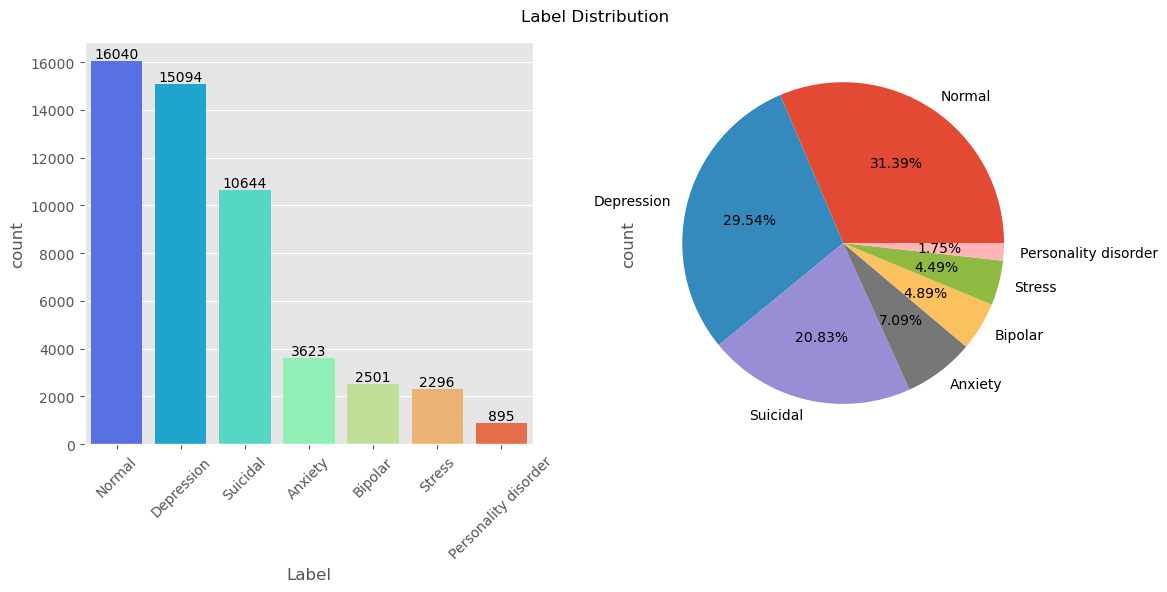

In [7]:
plt.figure(figsize=(12,6))
plt.suptitle('Label Distribution')
plt.subplot(1,2,1)
ax = sns.countplot(data = df, x = LABEL, palette='rainbow', order=df[LABEL].value_counts().index)
for bar in ax.containers:
    ax.bar_label(bar)
plt.xlabel('Label')
plt.ylabel('count')
plt.xticks(rotation = 45)
plt.subplot(1,2,2)
df[LABEL].value_counts().plot.pie(
    autopct="%.2f%%",
    labels=df[LABEL].value_counts().index,
)
plt.tight_layout()
plt.show()

## Cleaning Text

In [56]:
find_emoji = re.search( "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+", " ".join(df['statement'])) 
print("Emojis found in the dataset: ", True if find_emoji else False)

Emojis found in the dataset:  True


In [57]:
def clean_emoji(text):
  emoji_pattern = re.compile(
       "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+", flags=re.UNICODE
      )
  return emoji_pattern.sub(r'', text)


In [58]:
def demojize_emoji(text):
    emoji_pattern = re.compile(
        "["
         u"\U0001F600-\U0001F64F"  # emoticons
         u"\U0001F300-\U0001F5FF"  # symbols & pictographs
         u"\U0001F680-\U0001F6FF"  # transport & map symbols
         u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
         u"\U00002702-\U000027B0"
         u"\U000024C2-\U0001F251"
         "]+", flags=re.UNICODE
       )
    return emoji_pattern.sub(lambda x: re.sub(r'[\W_]', " ",emoji.demojize(x.group())), text)

text = "I love programming! 😍💻"

# example usage
cleaned_text = clean_emoji(text)
demojized_text = demojize_emoji(text)
print("Original Text: ", text)
print("Cleaned Text: ", cleaned_text)
print("Demojized Text: ", demojized_text)

Original Text:  I love programming! 😍💻
Cleaned Text:  I love programming! 
Demojized Text:  I love programming!  smiling face with heart eyes  laptop 


In [59]:
def cleaned_text(text):
  text = demojize_emoji(text)
  text = text.lower()
  text = re.sub(r'(im)\s', 'i am ', text)
  text = re.sub(r"can\'t|can t", "can not", text)
  text = re.sub(r"don\'t", "do not", text)
  text = re.sub(r"shouldn\'t", "should not", text)
  text = re.sub(r"needn\'t", "need not", text)
  text = re.sub(r"hasn\'t", "has not", text)
  text = re.sub(r"haven\'t", "have not", text)
  text = re.sub(r"weren\'t", "were not", text)
  text = re.sub(r"mightn\'t", "might not", text)
  text = re.sub(r"didn\'t", "did not", text)
  text = re.sub(r"it's|it s", "it is", text)
  text = re.sub(r"i'm|i m", "i am", text)
  text = re.sub(r"n\'t", " not", text)
  text = re.sub(r"\'re", " are", text)
  text = re.sub(r"\'s", " is", text)
  text = re.sub(r"\'d", " would", text)
  text = re.sub(r"\'ll", " will", text)
  text = re.sub(r"\'t", " not", text)
  text = re.sub(r"\'ve", " have", text)
  text = re.sub("gonna|gon na", "going to", text)
  text = re.sub("wanna|wan na", "want to", text)
  text = re.sub("rn", "right now", text)
  text = re.sub("idk", 'i dont know', text)
  text = re.sub(r"http?://\S+|www\.\S+|https?://\S+", '', text)
  text = re.sub('[^a-zA-Z0-9\s]', "", text)
  text = "".join([word for word in text if not word in string.punctuation])
  text = re.sub('[\n\t\r]', ' ', text)
  text = re.sub('\s+', ' ', text)

  return text

In [20]:
sample_text = df['statement'].sample(5).tolist()
print("Random statement: ")
for i, text in enumerate(sample_text, 1):
  print(f"{i}: {text}")

cleaned_sample = [cleaned_text(t) for t in sample_text]
print("Random cleaned statement: ")
for i, text in enumerate(cleaned_sample, 1):
  print(f"{i}: {text}")

Random statement: 
1: I take 100 mg orally How much zoloft is too much?
2: Sometimes my voice catches for a minute and I flush dark red. I feel like my heart is in my throat, like it's closed up a bit. Bump. Bump. Bump.
3: i am 17f and first of all, my family got issues with somebody else, they are bothering my family, they feel sad about it. but i do not let people to make me upset. my family is unhappy and busy. even though I do not care, seeing them sad makes me feel bad too. that is not the point, it was just a little info about fam, i love them, they love me long story short i do not have problem with them, they just have their own problemsi took too long so sorry for thati broke up with my boyfriend because i could not give him enough attention. not just my boyfriend, i cannot give attention to anything. nothing seems interesting i just lay down to the bed and waiting for the day to end, I stopped playing games, doing workout, my appetite is gone. i have no energy, i have no joy.

In [61]:
df['cleaned_text'] = df['statement'].apply(cleaned_text)
df.head()

,statement,status,cleaned_text
0,oh my gosh,Anxiety,oh my gosh
1,"trouble sleeping, confused mind, restless hear...",Anxiety,trouble sleeping confused mind restless heart ...
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,all wrong back off dear forward doubt stay in ...
3,I've shifted my focus to something else but I'...,Anxiety,i have shifted my focus to something else but ...
4,"I'm restless and restless, it's been a month n...",Anxiety,i am restless and restless it is been a month ...


In [62]:
STOPWORDS = stopwords.words('english')

## Wordclouds Viz

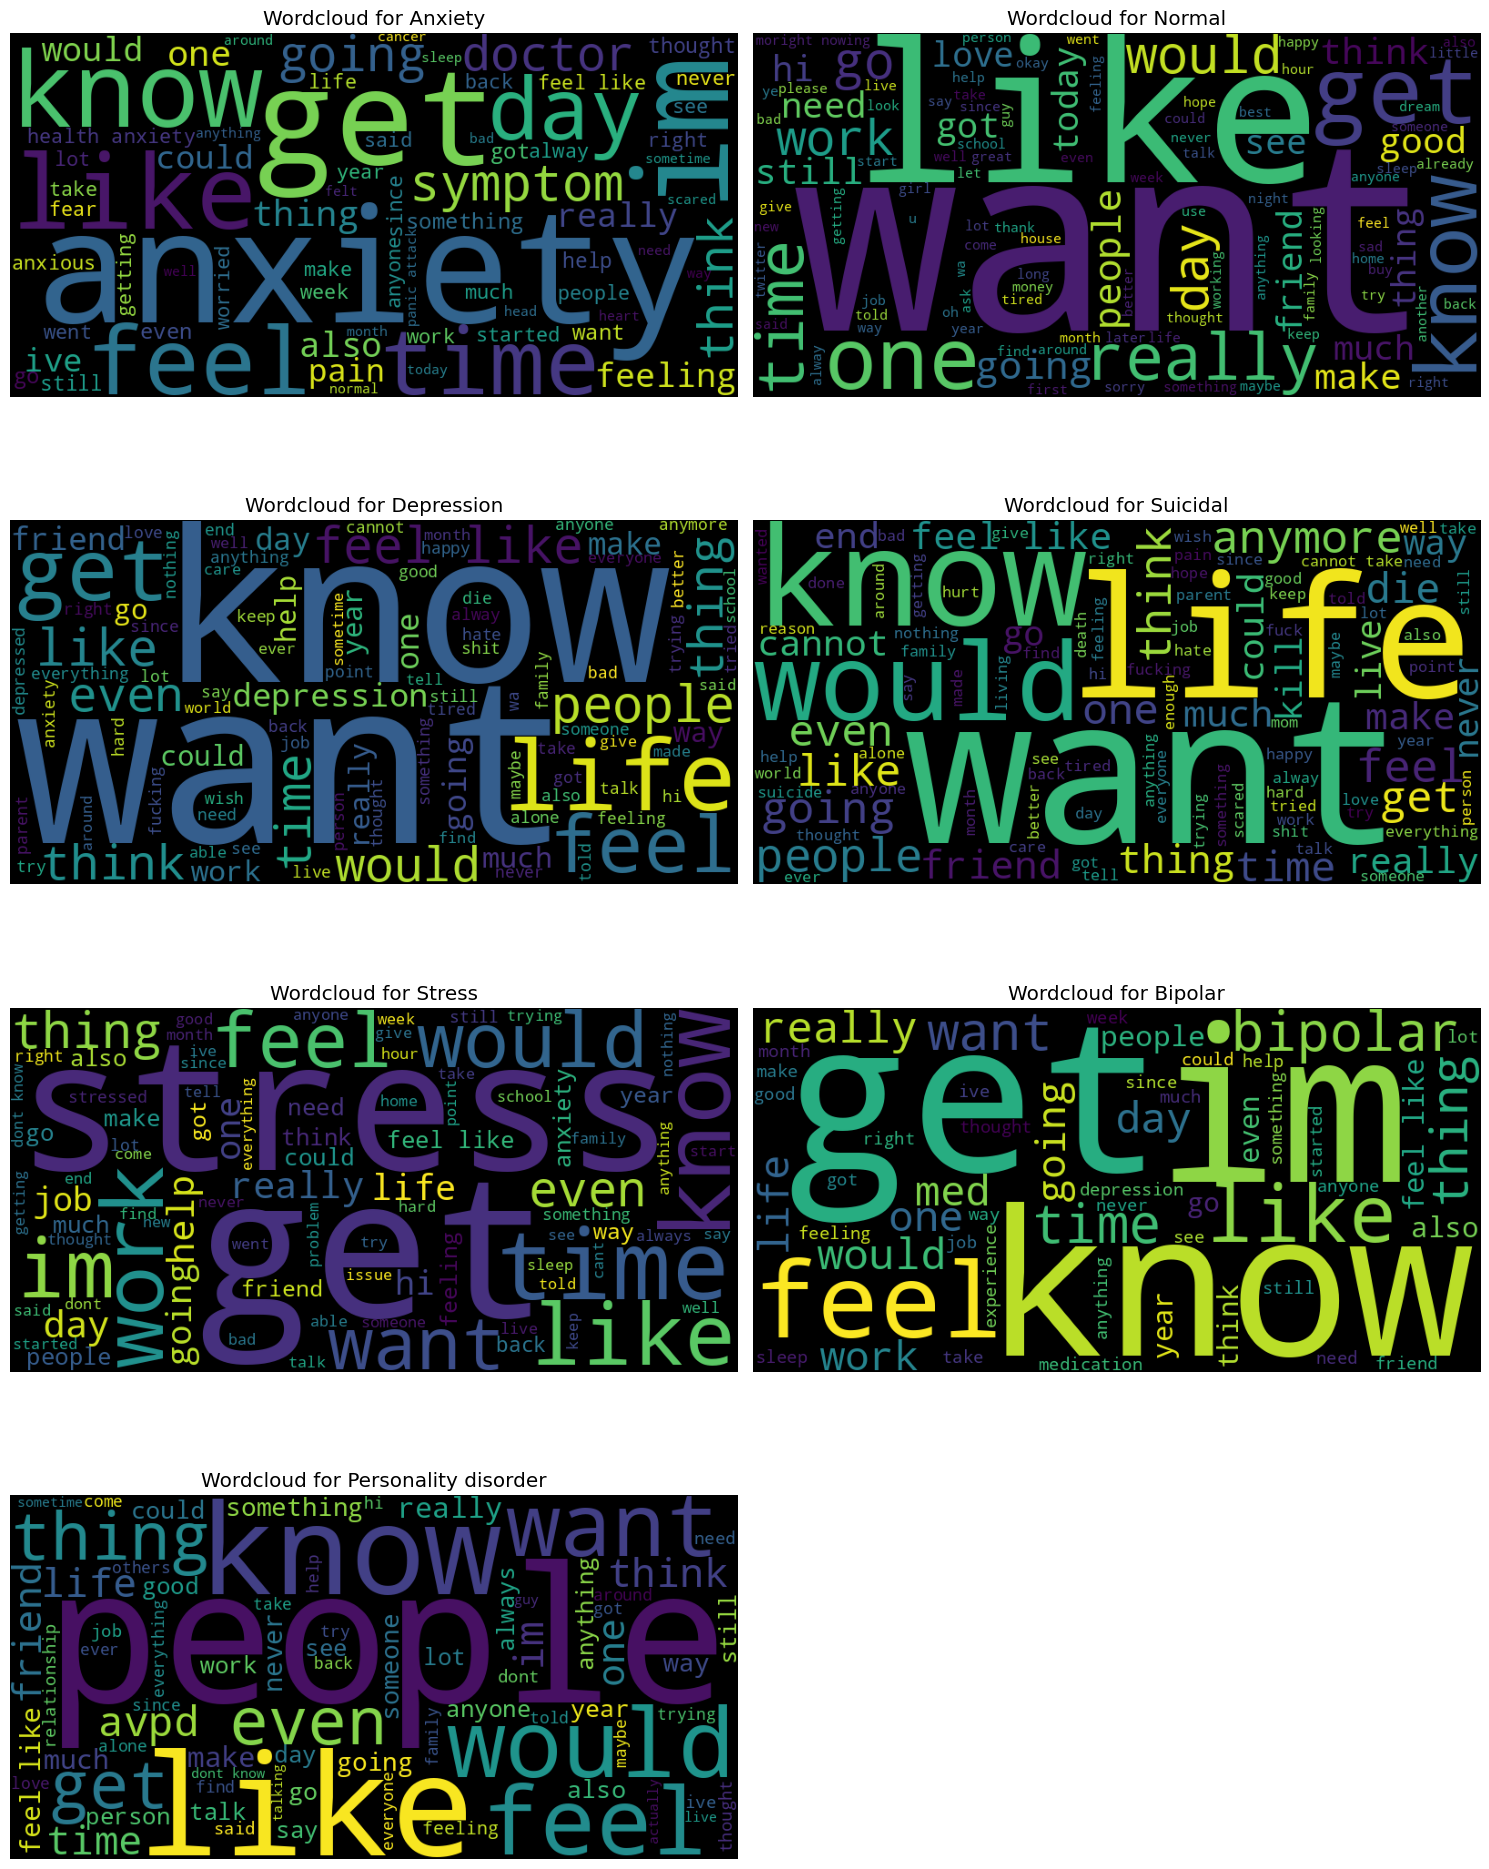

In [73]:
def wordcloud_plot(df, LABEL):
  label_unique = df[LABEL].unique()
  length = len(label_unique)
  cols = 2
  rows = length // cols + (length % cols > 0)
  plt.figure(figsize=(15, 5 * rows))
  for i, label in enumerate(label_unique, 1):
    plt.subplot(rows, cols, i)
    plt.title(f"Wordcloud for {label}")
    text = " ".join(df[df[LABEL] == label]['cleaned_text'])
    pos_wordcloud = WordCloud(
        background_color='black',
        height=400,
        width=800,
        stopwords=STOPWORDS,
        min_font_size=15
    ).generate(text)
    plt.imshow(pos_wordcloud)
    plt.axis('off')
  plt.tight_layout()
  plt.show

wordcloud_plot(df, LABEL)

## Top Words Viz

1: Anxiety - 254602 words


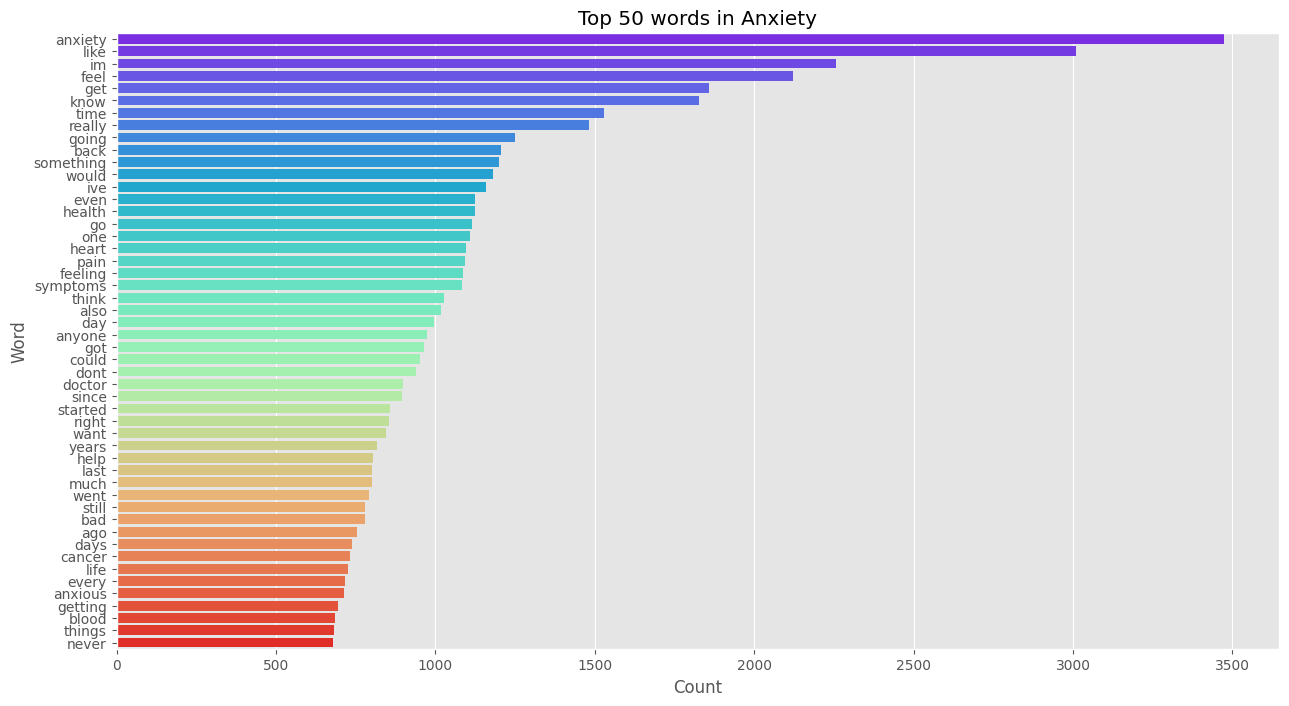

2: Normal - 143499 words


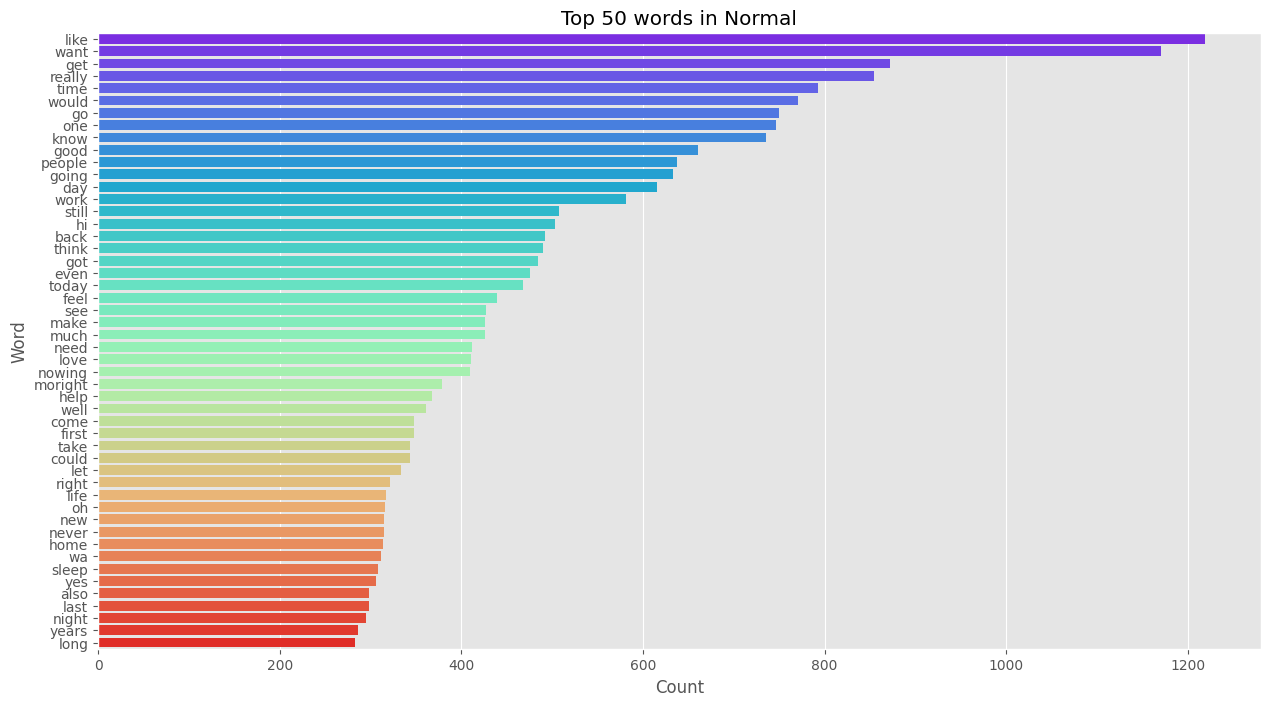

3: Depression - 1136908 words


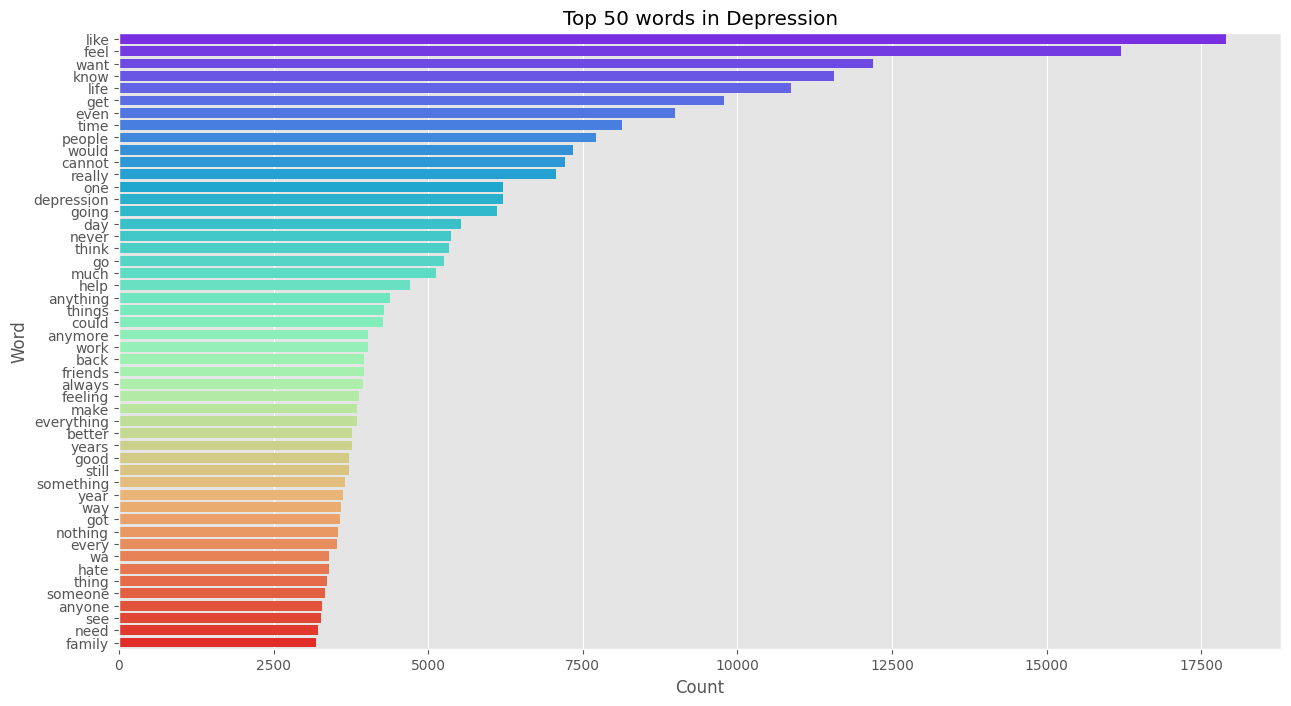

4: Suicidal - 687356 words


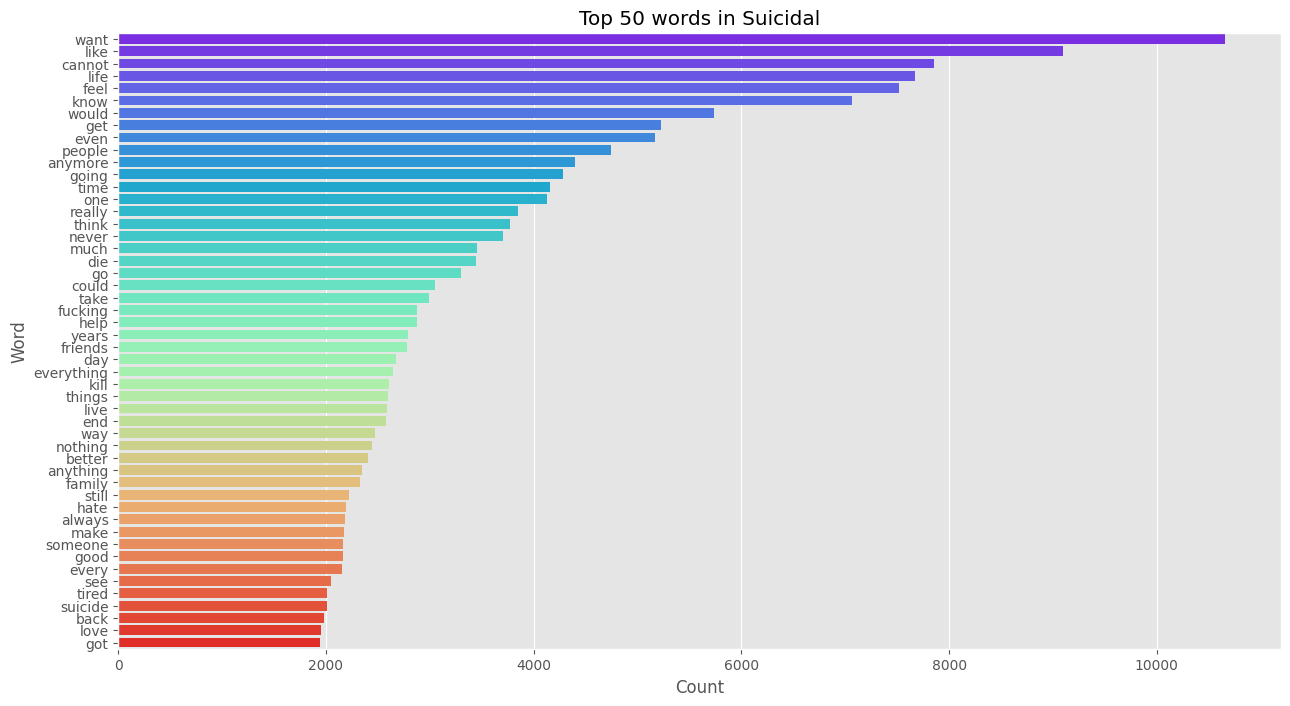

5: Stress - 121128 words


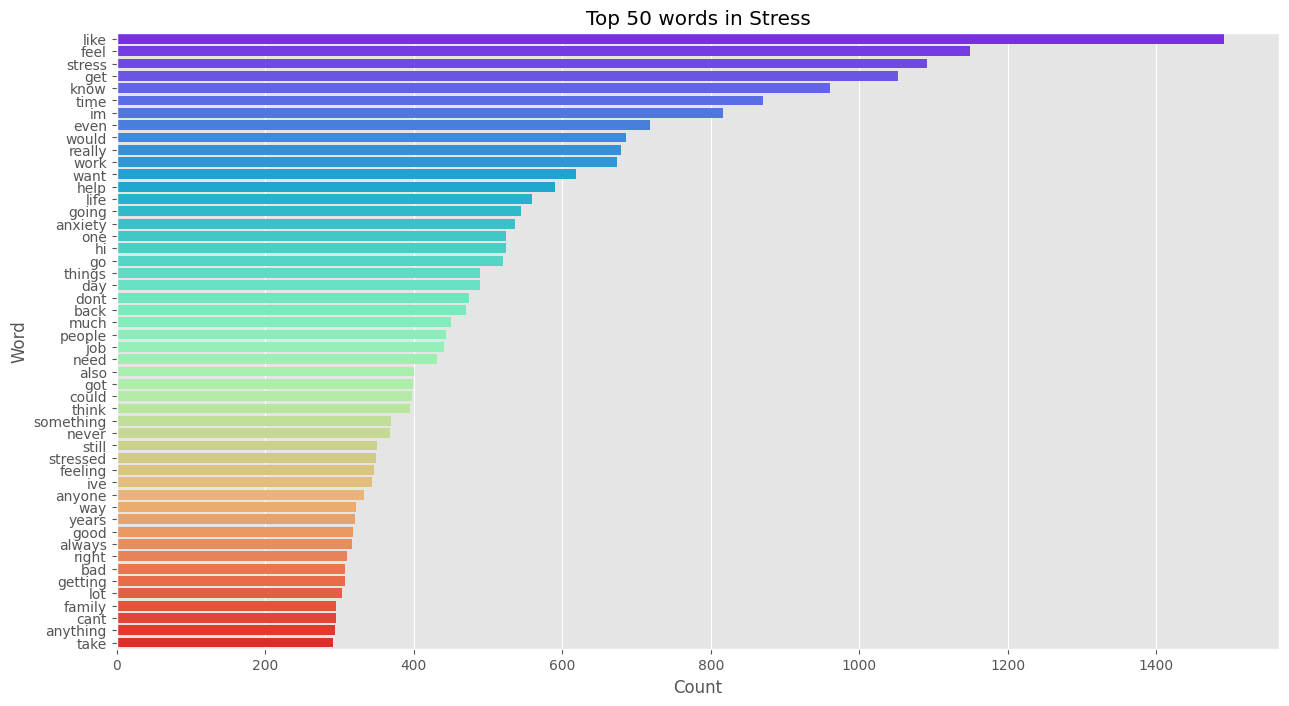

6: Bipolar - 215034 words


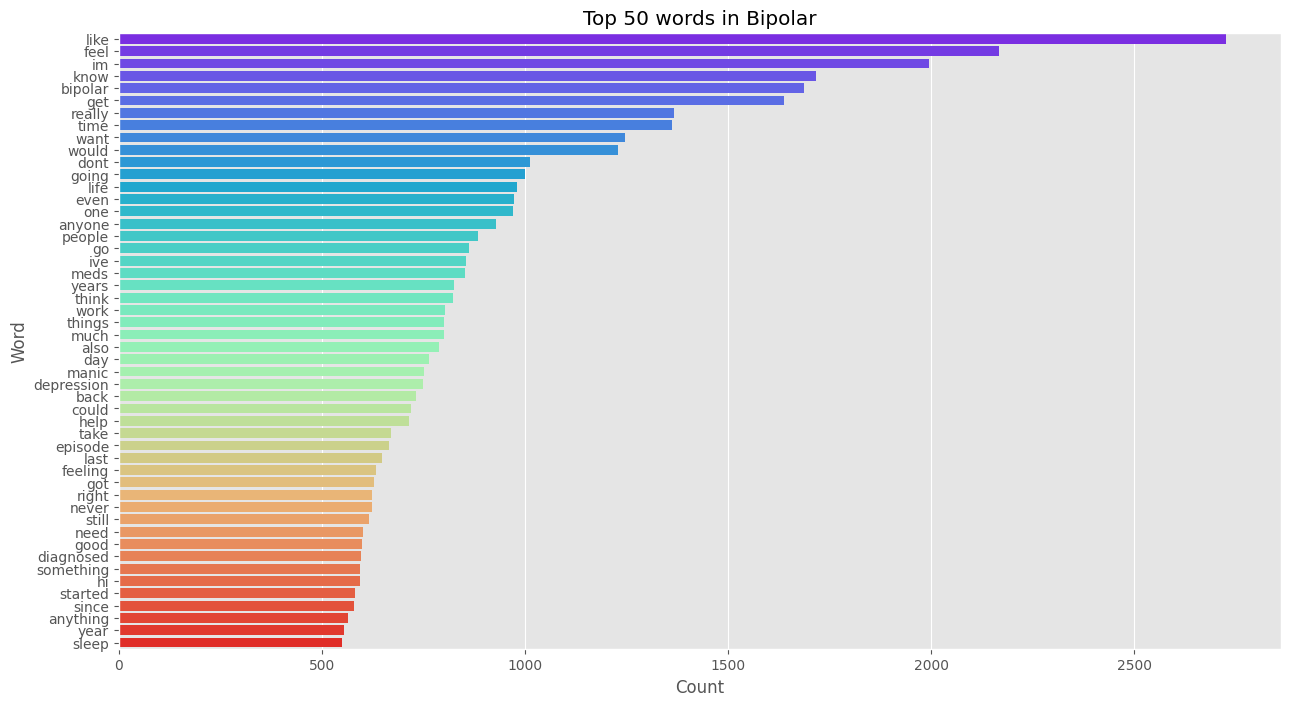

7: Personality disorder - 74391 words


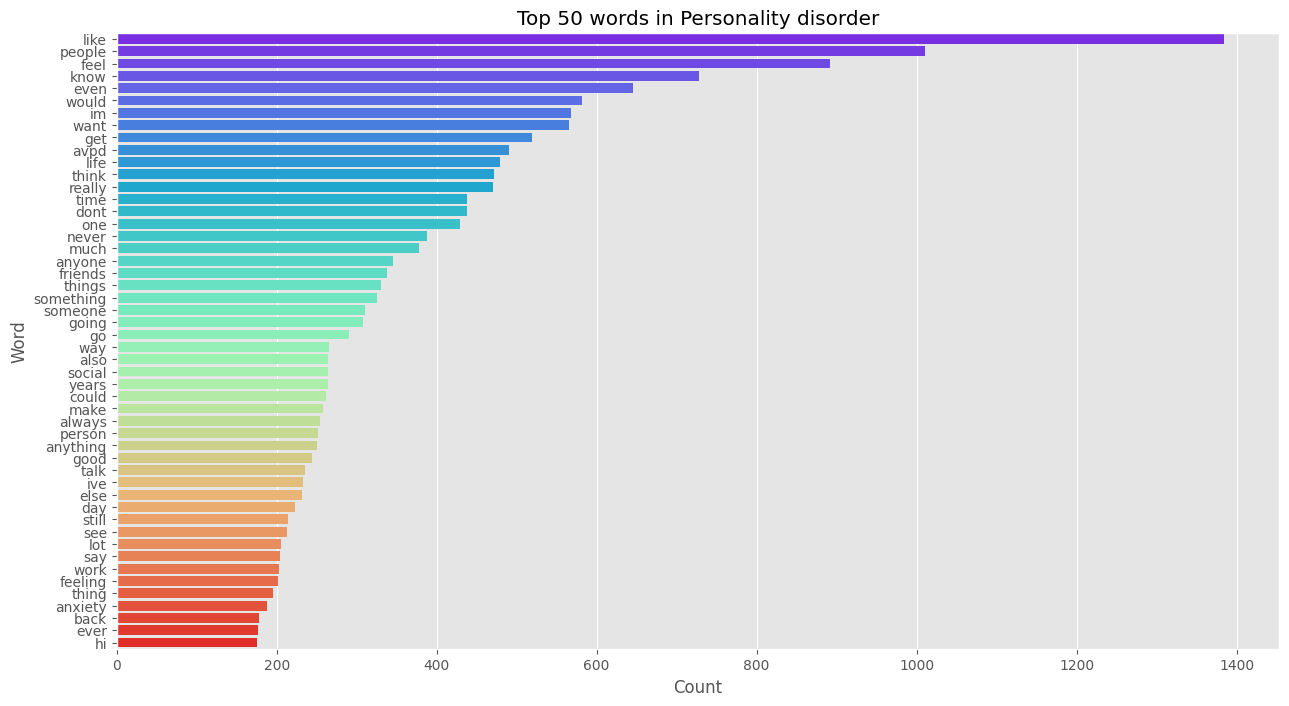

In [78]:
def make_corpus(df, label):
  corpus = []
  for text in df.loc[df[LABEL] == label, 'cleaned_text'].str.split():
    for word in text:
      if word not in STOPWORDS:
        corpus.append(word)
  return corpus

for i, label in enumerate(df[LABEL].unique(), 1):
  print(f"{i}: {label} - {len(make_corpus(df, label))} words")
  counter = Counter(make_corpus(df, label))
  mc = counter.most_common()

  w,c = [], []

  for word, count in mc[:50]:
    w.append(word)
    c.append(count)

  plt.figure(figsize=(15, 8))
  sns.barplot(x = c, y = w, palette='rainbow')
  plt.title(f"Top 50 words in {label}")
  plt.xlabel('Count')
  plt.ylabel('Word')
  plt.show()

# Feature Engineering

In [63]:
df['statement length'] = df['statement'].apply(len)
df.groupby(LABEL)['statement length'].describe().T

status,Anxiety,Bipolar,Depression,Normal,Personality disorder,Stress,Suicidal
count,3623.000000,2501.000000,15094.000000,16040.000000,895.000000,2296.000000,10644.000000
mean,761.249517,958.055978,844.764410,91.210474,949.450279,593.999129,735.396749
std,810.379970,977.126896,954.068227,120.762447,1207.825902,542.684545,982.444164
min,7.000000,27.000000,3.000000,2.000000,39.000000,6.000000,6.000000
25%,219.000000,401.000000,272.000000,29.000000,349.500000,339.000000,203.000000
50%,544.000000,702.000000,562.000000,51.000000,720.000000,451.000000,453.000000
75%,1007.500000,1182.000000,1078.000000,97.000000,1242.000000,641.500000,924.250000
max,8539.000000,26163.000000,19822.000000,1358.000000,27588.000000,8389.000000,32759.000000


In [64]:
from nltk import sent_tokenize, word_tokenize
tokenizer = RegexpTokenizer(r'\w+')

def add_features(df):
    df['contains_num'] = df['statement'].apply(lambda x: 1 if re.search(r'\d', x) else 0)
    df['capital_ratio'] = df['statement'].apply(
        lambda x: sum(1 for c in x if c.isupper()) / sum(1 for c in x if c.isalpha()) 
        if any(c.isalpha() for c in x) else 0
    )
    df['word_count'] = df['statement'].apply(lambda x: len(tokenizer.tokenize(x)))
    df['avg_word_length'] = df['statement'].apply(
        lambda x: np.mean([len(word) for word in word_tokenize(x)]) 
        if len(word_tokenize(x)) > 0 else 0
    )
    df['sentence_count'] = df['statement'].apply(lambda x: len(sent_tokenize(x)))
    df['avg_sentence_length'] = df['statement'].apply(
        lambda x: np.mean([len(sentence.split()) for sentence in sent_tokenize(x)]) 
        if len(sent_tokenize(x)) > 0 else 0
    )
    return df
df = add_features(df)
df.head()

,statement,status,cleaned_text,statement length,contains_num,capital_ratio,word_count,avg_word_length,sentence_count,avg_sentence_length
0,oh my gosh,Anxiety,oh my gosh,10,0,0.000000,3,2.666667,1,3.0
1,"trouble sleeping, confused mind, restless hear...",Anxiety,trouble sleeping confused mind restless heart ...,64,0,0.019231,10,4.230769,2,5.0
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,all wrong back off dear forward doubt stay in ...,78,0,0.032258,14,3.823529,2,7.0
3,I've shifted my focus to something else but I'...,Anxiety,i have shifted my focus to something else but ...,61,0,0.040816,13,3.923077,1,11.0
4,"I'm restless and restless, it's been a month n...",Anxiety,i am restless and restless it is been a month ...,72,0,0.037736,16,2.950000,2,7.0


In [67]:
def preprocess_lemmatization(df, col):
    lemmatizer = WordNetLemmatizer()
    tokenizer = RegexpTokenizer(r'\w+')
    def lemmatize_text(text):
        tokens = tokenizer.tokenize(text)
        lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in STOPWORDS]
        return ' '.join(lemmatized_tokens)
    df["lemmatized_text"] = df[col].apply(lemmatize_text)
    return df
df = preprocess_lemmatization(df, 'cleaned_text')

In [ ]:
df_cleaned = df.drop(columns=['statement'])
df_cleaned.head()
df_cleaned.to_csv('../data/data_cleaned.csv', index=False)